# Imports Necessary Modules

In [1]:
!pip install kaggle

In [11]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [01:43<00:00, 24.4MB/s]
100% 2.29G/2.29G [01:43<00:00, 23.7MB/s]


In [12]:
!unzip chest-xray-pneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating:

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:

import os
source_folder = '/content/chest_xray'
destination_folder = '/content/drive/MyDrive/chest_4'

!cp -r "{source_folder}" "{destination_folder}"

# Confirm that the folder is saved
if os.path.exists(destination_folder):
    print(f"Dataset successfully saved to {destination_folder}")
else:
    print("Failed to save the dataset to Google Drive.")

Dataset successfully saved to /content/drive/MyDrive/chest_4


# Imports Necessary Modules

In [7]:
import os
import cv2
import numpy as np
import tensorflow as tf
from random import sample
from os import mkdir, listdir
from collections import Counter
import matplotlib.pyplot as plt
from shutil import copyfile, rmtree
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings("ignore")

In [14]:
base_dir = '/content/drive/MyDrive/chest_4'

train_dir = f'{base_dir}/train'
valid_dir = f'{base_dir}/val'
test_dir = f'{base_dir}/test'

## Counting Images in the Training Set

In [21]:
print("Train set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))} images")
print(f"NORMAL={len(os.listdir(os.path.join(train_dir, 'NORMAL')))} images")

Train set:
PNEUMONIA=1075 images
NORMAL=1041 images


## Counting Images in the Test Set

In [22]:
print("Test set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(test_dir, 'PNEUMONIA')))} images")
print(f"NORMAL={len(os.listdir(os.path.join(test_dir, 'NORMAL')))} images")

Test set:
PNEUMONIA=390 images
NORMAL=234 images


## Counting Images in the Validation Set

In [23]:
print("Validation set:\n========================================")
print(f"PNEUMONIA={len(os.listdir(os.path.join(valid_dir, 'PNEUMONIA')))} images")
print(f"NORMAL={len(os.listdir(os.path.join(valid_dir, 'NORMAL')))} images")

Validation set:
PNEUMONIA=308 images
NORMAL=308 images


## Visualizing Image Counts Across Classes for Train, Validation, and Test Sets

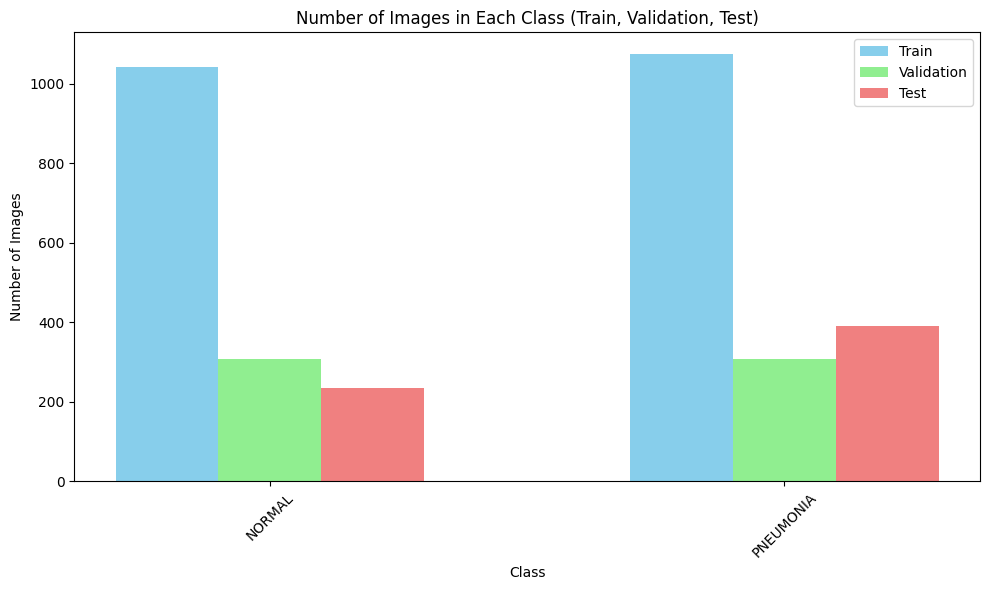

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt

def count_images_in_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_name] = num_images
    return class_counts

train_counts = count_images_in_classes(train_dir)
valid_counts = count_images_in_classes(valid_dir)
test_counts = count_images_in_classes(test_dir)
all_classes = list(train_counts.keys())
train_values = [train_counts.get(cls, 0) for cls in all_classes]
valid_values = [valid_counts.get(cls, 0) for cls in all_classes]
test_values = [test_counts.get(cls, 0) for cls in all_classes]
x = np.arange(len(all_classes))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x - width, train_values, width, label='Train', color='skyblue')
plt.bar(x, valid_values, width, label='Validation', color='lightgreen')
plt.bar(x + width, test_values, width, label='Test', color='lightcoral')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class (Train, Validation, Test)')
plt.xticks(x, all_classes, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## Preprocessing for Images Resizing and Normalization and convert to RGB

In [111]:
target_size = (299, 299)

def preprocessing(image):
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    return image

## Training, Validation, and Testing data with Augmentation

In [113]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing,
    rotation_range=10,
    width_shift_range=0.01,
    height_shift_range=0.01,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=preprocessing
)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=16,
    class_mode='binary',
    shuffle=True,

)

val_generator = val_test_datagen.flow_from_directory(
    valid_dir,
    target_size=target_size,
    batch_size=16,
    class_mode='binary',

)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=16,
    class_mode='binary',

)



data_patch, label_batch=next(train_generator)
print(f"first labels :{label_batch[:10]}")



Found 2116 images belonging to 2 classes.
Found 616 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
first labels :[1. 0. 1. 0. 1. 1. 1. 0. 1. 1.]


## Visualizing a Batch of Images with Their Labels from the Training Generator

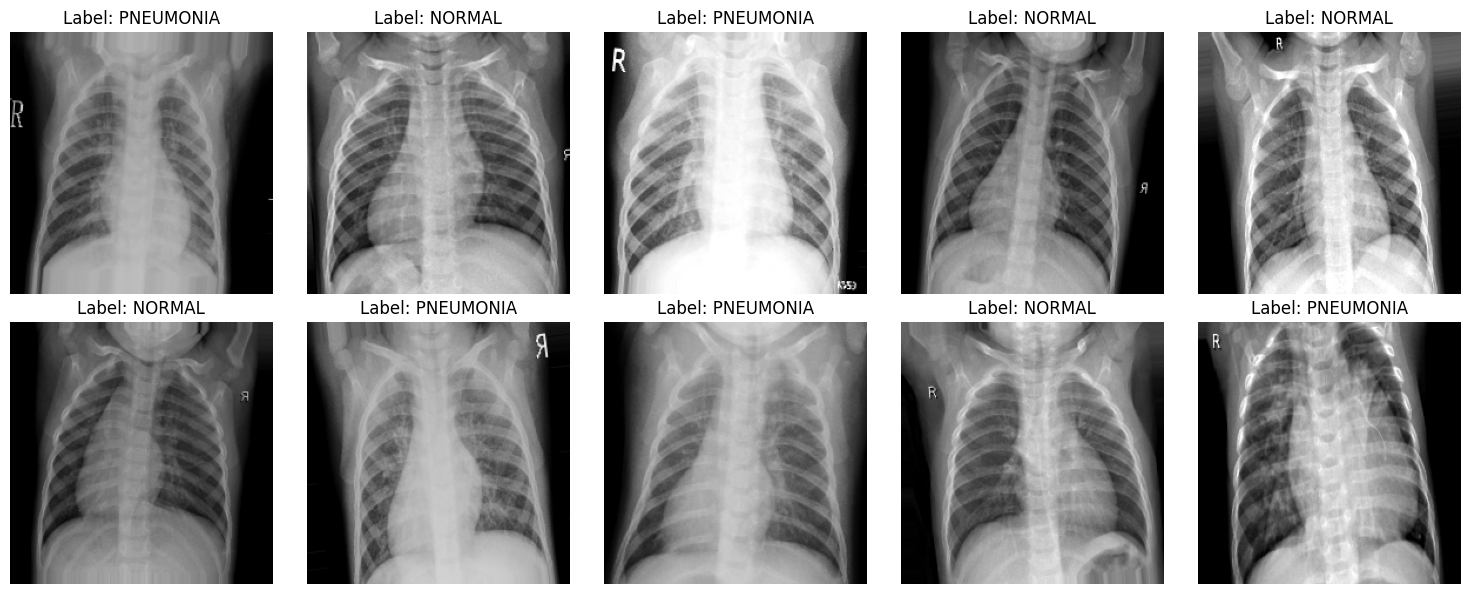

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_with_labels(generator, class_indices, num_images=10, images_per_row=5):
    images, labels = next(generator)
    num_images_in_batch = images.shape[0]
    num_images = min(num_images, num_images_in_batch)
    num_rows = int(np.ceil(num_images / images_per_row))
    indices = np.random.choice(num_images_in_batch, num_images, replace=False)

    plt.figure(figsize=(images_per_row * 3, num_rows * 3))
    for i, index in enumerate(indices):
        plt.subplot(num_rows, images_per_row, i + 1)
        plt.imshow(images[index])
        plt.axis('off')

        label = labels[index]
        class_label = list(class_indices.keys())[list(class_indices.values()).index(int(label))]
        plt.title(f'Label: {class_label}')

    plt.tight_layout()
    plt.show()
plot_images_with_labels(train_generator, class_indices=train_generator.class_indices, num_images=10, images_per_row=5)

# Xception Model

In [114]:
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import Xception
import tensorflow as tf

base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

for layer in base_model.layers[:36]:
    layer.trainable = False

for layer in base_model.layers[36:]:
    layer.trainable = True

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(255, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])



83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


# Train the Model

In [115]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)]
)

Epoch 1/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 192s 996ms/step - accuracy: 0.7218 - loss: 0.5701 - val_accuracy: 0.8117 - val_loss: 0.4222
Epoch 2/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 147s 840ms/step - accuracy: 0.9188 - loss: 0.2582 - val_accuracy: 0.9140 - val_loss: 0.2280
Epoch 3/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 134s 777ms/step - accuracy: 0.9458 - loss: 0.1603 - val_accuracy: 0.9399 - val_loss: 0.1598
Epoch 4/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 140s 767ms/step - accuracy: 0.9518 - loss: 0.1497 - val_accuracy: 0.9432 - val_loss: 0.1518
Epoch 5/5
133/133 ━━━━━━━━━━━━━━━━━━━━ 150s 830ms/step - accuracy: 0.9679 - loss: 0.1192 - val_accuracy: 0.9497 - val_loss: 0.1393


# Model Summary

In [116]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_10          │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_139 (Dropout)                │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 255)                 │         522,495 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_140 (Dropout)                │ (None, 255)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │             256 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,830,119 (235.86 MB)

 Trainable params: 20,222,943 (77.14 MB)

 Non-trainable params: 1,161,288 (4.43 MB)

 Optimizer params: 40,445,888 (154.29 MB)

#  Evaluating the Model Performance

In [117]:
test_loss, test_acc =model.evaluate(test_generator)
print(f"Test accuracy: {test_acc *100:.2f}%")

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - accuracy: 0.8997 - loss: 0.2567
Test accuracy: 91.19%


## Training and Validation Accuracy

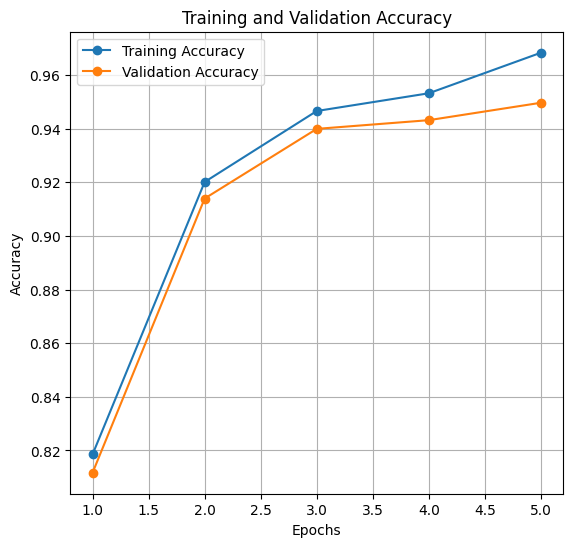

In [118]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

## Training and Validation Loss

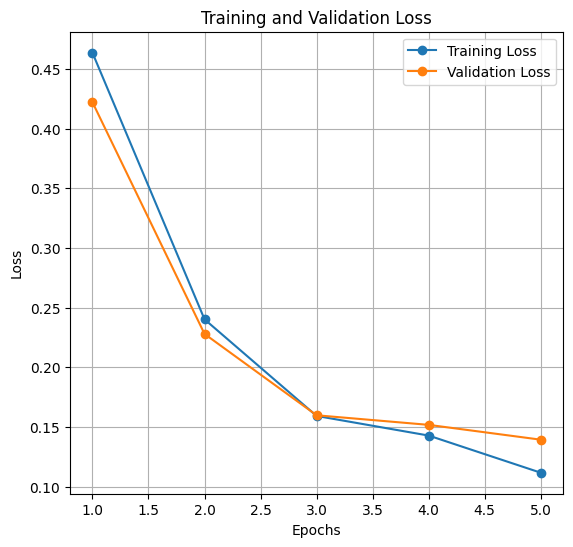

In [119]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)

plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# Saving the Model

In [123]:
model.save('Xception.h5')

# Load Trained Model and Predict Class from a New Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: NORMAL


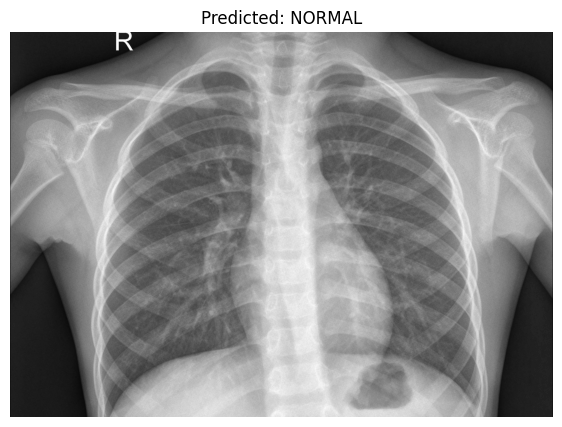

In [124]:
model = load_model('Xception.h5')
target_size = (299, 299)

def load_and_preprocess_image(image_path, target_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"Failed to load image from {image_path}")
    if len(image.shape) == 2:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    image = cv2.resize(image, target_size)
    image = image.astype(np.float32) / 255.0
    return image

image_path = '/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg'
image_for_prediction = load_and_preprocess_image(image_path, target_size)

image_for_prediction = np.expand_dims(image_for_prediction, axis=0)
prediction = model.predict(image_for_prediction)
predicted_class = np.argmax(prediction, axis=1)[0]
class_labels = ['NORMAL', 'PNEUMONIA']

print(f"Predicted: {class_labels[predicted_class]}")
plt.figure(figsize=(10, 5))
plt.imshow(cv2.imread(image_path, cv2.IMREAD_GRAYSCALE), cmap='gray')
plt.title(f"Predicted: {class_labels[predicted_class]}")
plt.axis('off')
plt.show()
